## Prequisites and Preprocessing

### Permissions and environment variables

_This notebook was created and tested on an ml.m4.xlarge notebook instance._

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

In [7]:
bucket = 'creditcarddatapkv'
prefix = 'sagemaker/DEMO-linear-cc'
 
# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

### Data ingestion

Next, we read the dataset from an online URL into memory, for preprocessing prior to training. This processing could be done *in situ* by Amazon Athena, Apache Spark in Amazon EMR, Amazon Redshift, etc., assuming the dataset is present in the appropriate location. Then, the next step would be to transfer the data to S3 for use in training. For small datasets, such as this one, reading into memory isn't onerous, though it would be for larger datasets.

In [2]:
%%time
import numpy, urllib.request, json
import pandas as pd

# Load the dataset
data_filename = "creditcard.csv"
urllib.request.urlretrieve("https://s3.amazonaws.com/creditcarddatapkv/creditcard.csv", data_filename)
df = pd.read_csv(data_filename, delimiter=',')

df.head()

CPU times: user 3.03 s, sys: 652 ms, total: 3.68 s
Wall time: 5.27 s


### Data inspection

Once the dataset is imported, it's typical as part of the machine learning process to inspect the data, understand the distributions, and determine what type(s) of preprocessing might be needed. You can perform those tasks right here in the notebook. As an example, let's go ahead and look at one of the digits that is part of the dataset.

0.1727485630620034


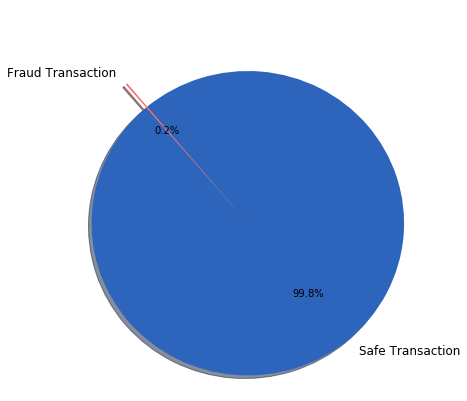

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7,7)
import seaborn as sns

perFraudCount = df.Class.where(df['Class']==1).count()/df.Class.count()*100
print(perFraudCount)

fig1, ax1 = plt.subplots()

labels = ['Fraud Transaction', 'Safe Transaction']
sizes = [perFraudCount, 100-perFraudCount]
explode = (0, 0.2)  # only "explode" the 2nd slice (i.e. 'Hogs')

patches, texts, autotexts = ax1.pie(sizes,  labels=labels, autopct='%1.1f%%', shadow = True, explode=explode, startangle=130, colors = ['#ff6666', '#2d64bc'])
texts[0].set_fontsize(12)
texts[1].set_fontsize(12)


Text(0.5,1,'Class Distributions \n (0: No Fraud || 1: Fraud)')

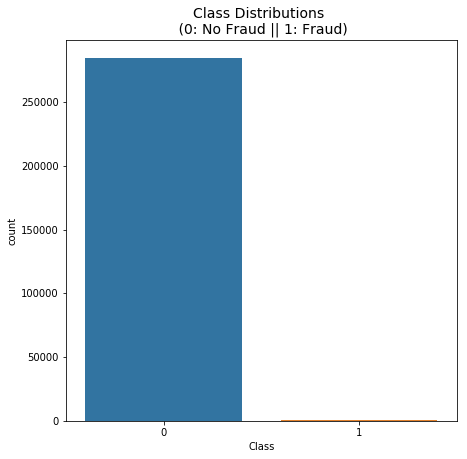

In [21]:

sns.countplot('Class', data=df)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

### Data conversion

Since algorithms have particular input and output requirements, converting the dataset is also part of the process that a data scientist goes through prior to initiating training. In this particular case, the Amazon SageMaker implementation of Linear Learner takes recordIO-wrapped protobuf, where the data we have today is a pickle-ized numpy array on disk.

Most of the conversion effort is handled by the Amazon SageMaker Python SDK, imported as `sagemaker` below.

In [13]:
import io
import numpy as np
import sagemaker.amazon.common as smac
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix


columns = df.columns
labels = df['Class']
features = df.drop(['Class'], axis=1)

#Train test split
features_train, features_test, labels_train, labels_test = train_test_split(features, 
                                                                            labels, 
                                                                            test_size=0.2, 
                                                                            random_state=0)
buf = io.BytesIO()
#Convert to float32 as currently float64 not supported
features_train = features_train.astype('float32')
labels_train = labels_train.astype('float32')
smac.write_numpy_to_dense_tensor(buf, features_train.values, labels_train.values)
buf.seek(0)


0

In [5]:
#Raw Predictions based upon Random Forrest Classifier
clf = RandomForestClassifier(random_state=0)
clf.fit(features_train, labels_train)
actual = labels_test
predictions = clf.predict(features_test)
predictions_scores = clf.predict_proba(features_test)[:,1]

In [29]:
#Confusion matrix:
confusion_matrix(actual, predictions)

array([[56855,     6],
       [   26,    75]])

## Upload training data
Now that we've created our recordIO-wrapped protobuf, we'll need to upload it to S3, so that Amazon SageMaker training can use it.

In [15]:
import boto3
import os

key = 'recordio-pb-data'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

uploaded training data location: s3://creditcarddatapkv/sagemaker/DEMO-linear-cc/train/recordio-pb-data


Let's also setup an output S3 location for the model artifact that will be output as the result of training with the algorithm.

In [16]:
output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('training artifacts will be uploaded to: {}'.format(output_location))

training artifacts will be uploaded to: s3://creditcarddatapkv/sagemaker/DEMO-linear-cc/output


## Training the linear model

Once we have the data preprocessed and available in the correct format for training, the next step is to actually train the model using the data. Since this data is relatively small, it isn't meant to show off the performance of the Linear Learner training algorithm, although we have tested it on multi-terabyte datasets.

Again, we'll use the Amazon SageMaker Python SDK to kick off training, and monitor status until it is completed.  In this example that takes between 7 and 11 minutes.  Despite the dataset being small, provisioning hardware and loading the algorithm container take time upfront.

First, let's specify our containers.  Since we want this notebook to run in all 4 of Amazon SageMaker's regions, we'll create a small lookup.  More details on algorithm containers can be found in [AWS documentation](https://docs-aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html).

In [17]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'linear-learner')

'''Next we'll kick off the base estimator, making sure to pass in the necessary hyperparameters.  Notice:
- `feature_dim` is set to 30, which is the number of features.
- `predictor_type` is set to 'binary_classifier' since we are trying to predict whether the class is 0(genuine) or 1(fraud).
- `mini_batch_size` is set to 200.  This value can be tuned for relatively minor improvements in fit and speed, but selecting a reasonable value relative to the dataset is appropriate in most cases.'''

In [18]:
import boto3
import sagemaker

sess = sagemaker.Session()

linear = sagemaker.estimator.Estimator(container,
                                       role, 
                                       train_instance_count=1, 
                                       train_instance_type='ml.c4.xlarge',
                                       output_path=output_location,
                                       sagemaker_session=sess)
#list the of features
linear.set_hyperparameters(feature_dim=30,
                           predictor_type='binary_classifier',
                           mini_batch_size=200)

linear.fit({'train': s3_train_data})

INFO:sagemaker:Creating training-job with name: linear-learner-2018-09-29-14-22-45-906


2018-09-29 14:22:46 Starting - Starting the training job...
Launching requested ML instances......
Preparing the instances for training...
2018-09-29 14:24:33 Downloading - Downloading input data
2018-09-29 14:24:41 Training - Downloading the training image....
Docker entrypoint called with argument(s): train
[09/29/2018 14:25:18 INFO 140059234826048] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_method': u'uniform', u'init_sigma': u'0.01', u'lr_scheduler_minimum_lr': u'auto', u'target_recall': u'0.8', u'num_models': u'auto', u'early_stopping_patience': u'3', u'moment

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0055034703522580455, "sum": 0.0055034703522580455, "min": 0.0055034703522580455}}, "EndTime": 1538231180.865168, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 1}, "StartTime": 1538231180.865093}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004706383570505402, "sum": 0.004706383570505402, "min": 0.004706383570505402}}, "EndTime": 1538231180.865249, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 1}, "StartTime": 1538231180.865237}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.005508207023745571, "sum": 0.005508207023745571, "min": 0.005508207023745571}}, "EndTime": 1538231180.865299, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algor

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004912773151477248, "sum": 0.004912773151477248, "min": 0.004912773151477248}}, "EndTime": 1538231211.547713, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1538231211.547654}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004355304205235784, "sum": 0.004355304205235784, "min": 0.004355304205235784}}, "EndTime": 1538231211.547796, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 2}, "StartTime": 1538231211.547779}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004916321897684638, "sum": 0.004916321897684638, "min": 0.004916321897684638}}, "EndTime": 1538231211.54785, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004733598070894552, "sum": 0.004733598070894552, "min": 0.004733598070894552}}, "EndTime": 1538231242.359716, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1538231242.359655}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004282587239742802, "sum": 0.004282587239742802, "min": 0.004282587239742802}}, "EndTime": 1538231242.359793, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 3}, "StartTime": 1538231242.35978}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004733070824900356, "sum": 0.004733070824900356, "min": 0.004733070824900356}}, "EndTime": 1538231242.359828, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0046646679206518256, "sum": 0.0046646679206518256, "min": 0.0046646679206518256}}, "EndTime": 1538231274.629297, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 4}, "StartTime": 1538231274.629237}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004223730083852614, "sum": 0.004223730083852614, "min": 0.004223730083852614}}, "EndTime": 1538231274.629381, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 4}, "StartTime": 1538231274.629364}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004622332801399679, "sum": 0.004622332801399679, "min": 0.004622332801399679}}, "EndTime": 1538231274.629437, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algor

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004634918854674088, "sum": 0.004634918854674088, "min": 0.004634918854674088}}, "EndTime": 1538231306.450122, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 5}, "StartTime": 1538231306.450061}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004209647187693298, "sum": 0.004209647187693298, "min": 0.004209647187693298}}, "EndTime": 1538231306.450208, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 5}, "StartTime": 1538231306.45019}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004511542140430165, "sum": 0.004511542140430165, "min": 0.004511542140430165}}, "EndTime": 1538231306.45026, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm"

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004613957320183803, "sum": 0.004613957320183803, "min": 0.004613957320183803}}, "EndTime": 1538231338.779407, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 1538231338.779346}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004168385492737509, "sum": 0.004168385492737509, "min": 0.004168385492737509}}, "EndTime": 1538231338.77949, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 6}, "StartTime": 1538231338.779472}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004419332893926706, "sum": 0.004419332893926706, "min": 0.004419332893926706}}, "EndTime": 1538231338.779544, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004590664368067215, "sum": 0.004590664368067215, "min": 0.004590664368067215}}, "EndTime": 1538231371.700132, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 7}, "StartTime": 1538231371.700072}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004160448434788004, "sum": 0.004160448434788004, "min": 0.004160448434788004}}, "EndTime": 1538231371.700209, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 7}, "StartTime": 1538231371.700196}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004353864015757881, "sum": 0.004353864015757881, "min": 0.004353864015757881}}, "EndTime": 1538231371.700244, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorith

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004567497949965488, "sum": 0.004567497949965488, "min": 0.004567497949965488}}, "EndTime": 1538231402.511192, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 8}, "StartTime": 1538231402.511117}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004130807796491537, "sum": 0.004130807796491537, "min": 0.004130807796491537}}, "EndTime": 1538231402.511283, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 8}, "StartTime": 1538231402.511265}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004309088630083363, "sum": 0.004309088630083363, "min": 0.004309088630083363}}, "EndTime": 1538231402.511336, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorith

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004545922024311257, "sum": 0.004545922024311257, "min": 0.004545922024311257}}, "EndTime": 1538231433.884025, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 9}, "StartTime": 1538231433.883964}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004127800562897332, "sum": 0.004127800562897332, "min": 0.004127800562897332}}, "EndTime": 1538231433.884111, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 9}, "StartTime": 1538231433.884093}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.00427685381551915, "sum": 0.00427685381551915, "min": 0.00427685381551915}}, "EndTime": 1538231433.884165, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algorithm":

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.004526409928386833, "sum": 0.004526409928386833, "min": 0.004526409928386833}}, "EndTime": 1538231466.419056, "Dimensions": {"model": 0, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 10}, "StartTime": 1538231466.418994}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.00410285943404455, "sum": 0.00410285943404455, "min": 0.00410285943404455}}, "EndTime": 1538231466.419141, "Dimensions": {"model": 1, "Host": "algo-1", "Operation": "training", "Algorithm": "Linear Learner", "epoch": 10}, "StartTime": 1538231466.419123}

#metrics {"Metrics": {"train_binary_classification_cross_entropy_objective": {"count": 1, "max": 0.0042518134162000025, "sum": 0.0042518134162000025, "min": 0.0042518134162000025}}, "EndTime": 1538231466.419195, "Dimensions": {"model": 2, "Host": "algo-1", "Operation": "training", "Algori


2018-09-29 14:31:14 Uploading - Uploading generated training model
2018-09-29 14:31:20 Completed - Training job completed
[09/29/2018 14:31:11 INFO 140059234826048] #train_score (algo-1) : ('binary_classification_cross_entropy_objective', 0.0039771025580632377)
[09/29/2018 14:31:11 INFO 140059234826048] #train_score (algo-1) : ('binary_classification_accuracy', 0.99928021242511356)
[09/29/2018 14:31:11 INFO 140059234826048] #train_score (algo-1) : ('binary_f_1.000', 0.7913486005089059)
[09/29/2018 14:31:11 INFO 140059234826048] #train_score (algo-1) : ('precision', 0.7873417721518987)
[09/29/2018 14:31:11 INFO 140059234826048] #train_score (algo-1) : ('recall', 0.7953964194373402)
[09/29/2018 14:31:11 INFO 140059234826048] #quality_metric: host=algo-1, train binary_classification_cross_entropy_objective <loss>=0.00397710255806
[09/29/2018 14:31:11 INFO 140059234826048] #quality_metric: host=algo-1, train binary_classification_accuracy <score>=0.999280212425
[09/29/2018 14:31:11 INFO 1

## Set up hosting for the model
Now that we've trained our model, we can deploy it behind an Amazon SageMaker real-time hosted endpoint.  This will allow out to make predictions (or inference) from the model dyanamically.

_Note, Amazon SageMaker allows you the flexibility of importing models trained elsewhere, as well as the choice of not importing models if the target of model creation is AWS Lambda, AWS Greengrass, Amazon Redshift, Amazon Athena, or other deployment target._

In [19]:
linear_predictor = linear.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: linear-learner-2018-09-29-14-37-46-840
INFO:sagemaker:Creating endpoint with name linear-learner-2018-09-29-14-22-45-906


---------------------------------------------------------------------------!

## Validate the model for use
Finally, we can now validate the model for use.  We can pass HTTP POST requests to the endpoint to get back predictions.  To make this easier, we'll again use the Amazon SageMaker Python SDK and specify how to serialize requests and deserialize responses that are specific to the algorithm.

In [21]:
from sagemaker.predictor import csv_serializer, json_deserializer

linear_predictor.content_type = 'text/csv'
linear_predictor.serializer = csv_serializer
linear_predictor.deserializer = json_deserializer

Now let's try getting a prediction for a single record.

In [30]:
result = linear_predictor.predict(features_test.iloc[0,:])
print(result)

{'predictions': [{'score': 0.0005234979325905442, 'predicted_label': 0.0}]}


OK, a single prediction works.  We see that for one record our endpoint returned some JSON which contains `predictions`, including the `score` and `predicted_label`.  In this case, `score` will be a value [0, 1] representing the probability we think the class is a 0 or not.  `predicted_label` will take a value of either `0` or `1` where (somewhat counterintuitively) `1` denotes that we predict the class is a 0, while `0` denotes that we are predicting the class is not of a 0.

Let's do a whole batch of test set and evaluate our predictive accuracy.

In [36]:
import numpy as np

predictions = []
for array in np.array(features_test):
    result = linear_predictor.predict(array)
    predictions += [r['predicted_label'] for r in result['predictions']]

predictions = np.array(predictions)

In [42]:
import pandas as pd

pd.crosstab(labels_test, predictions, rownames=['actuals'], colnames=['predictions'])

predictions,0.0,1.0
actuals,,
0,56844,17
1,20,81


### (Optional) Delete the Endpoint

If you're ready to be done with this notebook, please run the delete_endpoint line in the cell below.  This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [ ]:
import sagemaker

sagemaker.Session().delete_endpoint(linear_predictor.endpoint)